In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('data/loan_data_2007_2014.csv')
credit_score_w_id_only = pd.read_csv('data/loan_result.csv')
df_cleaned = pd.read_csv('data/loan_cleaned_v1.csv')

C:\Users\ACER\AppData\Local\Temp\ipykernel_26336\3926690796.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/loan_data_2007_2014.csv')


In [4]:
df_result = pd.merge(df,df_cleaned[['id','pymnt_time','credit_pull_year']],on = 'id')
df_result = pd.merge(df_result, credit_score_w_id_only,on='id')

In [5]:
df_result.sample(10)

,Unnamed: 0,id,member_id_x,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,pymnt_time,credit_pull_year,member_id_y,Credit Score
204817,204817,1453402,1707155,5600,5600,5600.000000,36 months,14.09,191.64,B,...,NaN,NaN,NaN,NaN,NaN,NaN,6,16,1707155,436.0
216404,216404,1301091,1545655,7750,7750,7750.000000,36 months,10.74,252.78,B,...,NaN,NaN,NaN,NaN,NaN,NaN,9,11,1545655,410.0
75905,75905,7956850,9678899,22800,22800,22800.000000,60 months,15.10,543.61,C,...,NaN,NaN,23400.0,NaN,NaN,NaN,4,15,9678899,569.0
140034,140034,5026405,6328629,18000,18000,18000.000000,36 months,21.49,682.69,E,...,NaN,NaN,29900.0,NaN,NaN,NaN,32,14,6328629,488.0
290121,290121,29784764,32307985,10000,10000,10000.000000,36 months,10.15,323.38,B,...,NaN,NaN,9000.0,NaN,NaN,NaN,11,11,32307985,519.0
432080,432080,12398912,14411042,9000,9000,9000.000000,36 months,7.90,281.62,A,...,NaN,NaN,72200.0,NaN,NaN,NaN,1,17,14411042,469.0
22087,22087,634553,812902,10000,10000,9475.000000,36 months,6.91,308.36,A,...,NaN,NaN,NaN,NaN,NaN,NaN,56,20,812902,548.0
24546,24546,599847,769934,6500,6500,6496.159652,36 months,6.17,198.25,A,...,NaN,NaN,NaN,NaN,NaN,NaN,27,17,769934,435.0
454911,454911,10628405,12500344,1450,1450,1450.000000,36 months,14.98,50.26,C,...,NaN,NaN,3700.0,NaN,NaN,NaN,1,26,12500344,462.0
273456,273456,32168239,34781415,15000,15000,15000.000000,36 months,8.39,472.75,A,...,NaN,NaN,38000.0,NaN,NaN,NaN,2,31,34781415,448.0


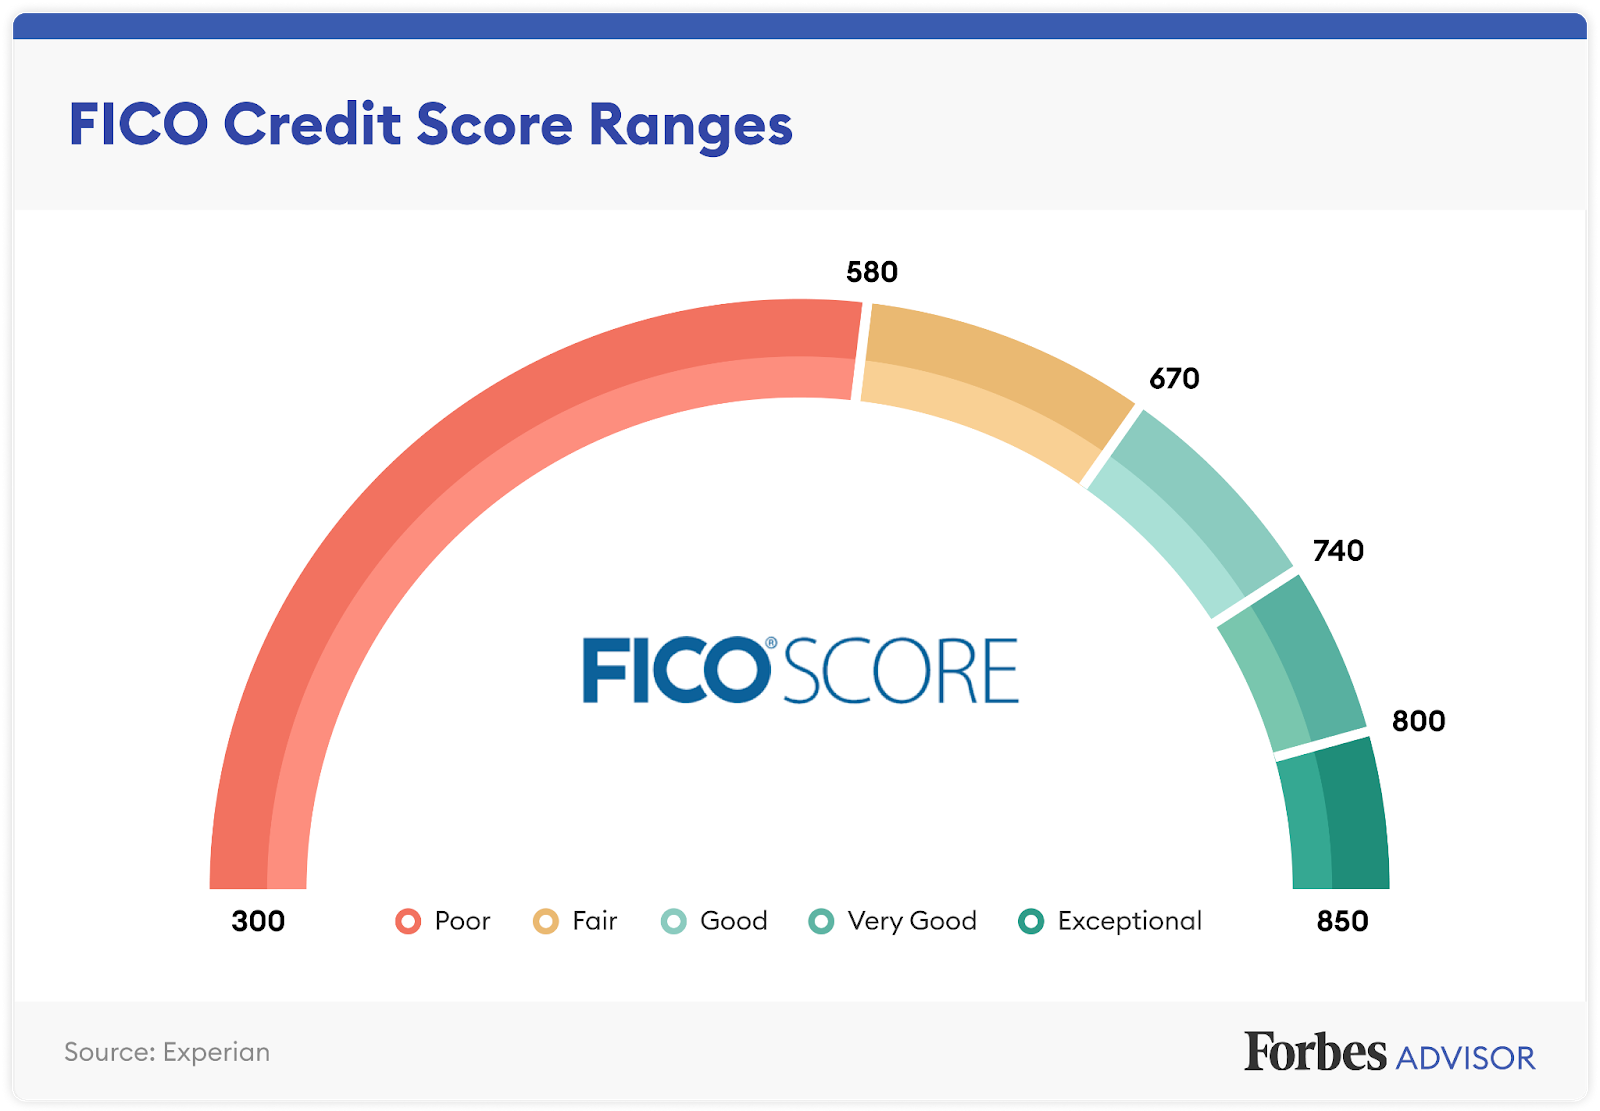

We will group credit score based on 'Forbes Advisor'.<br>
source = https://www.forbes.com/advisor/credit-score/what-is-a-fico-score/

In [7]:
df_vis = df_result.copy()

In [8]:
df_vis['score_group'] = np.where((df_vis['Credit Score']>=280)&(df_vis['Credit Score']<580),'Poor (300-579)',
                               np.where((df_vis['Credit Score']>= 580)&(df_vis['Credit Score']<670),'Fair (580-669)',
                               np.where((df_vis['Credit Score']>= 670)&(df_vis['Credit Score']<740),'Good (670-739)',
                               np.where((df_vis['Credit Score']>= 740)&(df_vis['Credit Score']<800),'Good (740-800)','Excellent (801-850)'))))

In [9]:
score_groupby = df_vis.groupby(['score_group']).agg(num_cust = ('id','count')).reset_index()
score_groupby['percentage'] = round((score_groupby ['num_cust']/466285)*100, 2)
score_groupby = score_groupby.sort_values('percentage',ascending = False)
score_groupby

,score_group,num_cust,percentage
1,Poor (300-579),463140,99.33
0,Fair (580-669),3145,0.67


[Text(0, 5, '99.33%'), Text(0, 5, '0.67%')]

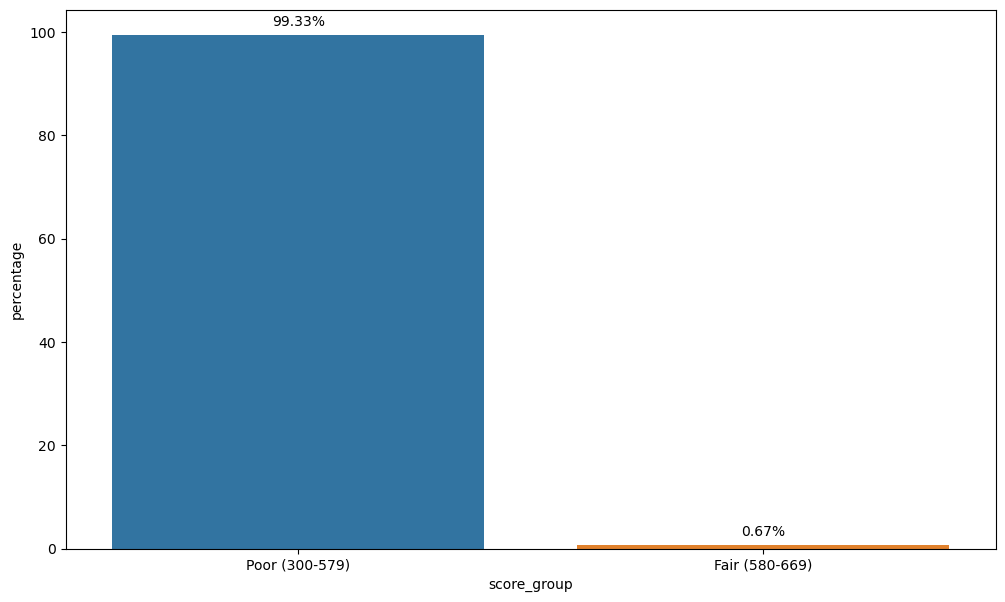

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = score_groupby['score_group'],y =score_groupby['percentage'],orient='v')
plt.bar_label(ax.containers[0], padding=5,fmt='%.2f%%')


* Feature `score_group` explain that majority of customer in this dataset was on credit score Poor group (300-579) by 99.20% while 0.80% on Fair (580-669).<br>
* No customer has credit score above 670 based on scoring using logistic regression. <br>
* Lenders must be careful in providing loans to customers and find solutions on how to take advantage of this situation.

### Adjusting Label to Visualization

In [11]:
#Adjusting Label on loan_status
good_loan = ['Current','Fully Paid','In Grace Period']
df_vis['loan_status'] = np.where(df_vis['loan_status'].isin(good_loan),'Good Loan','Bad Loan')

#Adjusting Label on loan_amnt
df_vis['loan_amnt_fc'] = np.where((df_vis['loan_amnt']>=465.5)&(df_vis['loan_amnt']< 3950),'465-3950',
                            np.where((df_vis['loan_amnt']>= 3950)&(df_vis['loan_amnt']<7400),'3950-7400',
                            np.where((df_vis['loan_amnt']>= 7400.0)&(df_vis['loan_amnt']<10850.0),'7400-10850',
                            np.where((df_vis['loan_amnt']>= 10850.0)&(df_vis['loan_amnt']<14300.0),'10850-14300',
                            np.where((df_vis['loan_amnt']>= 14300.0)&(df_vis['loan_amnt']<17750.0),'14300-17750',
                            np.where((df_vis['loan_amnt']>= 17750.0)&(df_vis['loan_amnt']<21200.0),'17750-21200',
                            np.where((df_vis['loan_amnt']>= 21200.0)&(df_vis['loan_amnt']<24650.0),'21200-24650',
                            np.where((df_vis['loan_amnt']>= 24650.0)&(df_vis['loan_amnt']<28100.0),'24650-28100',
                            np.where((df_vis['loan_amnt']>= 28100.0)&(df_vis['loan_amnt']<31550.0),'28100-31550','31550-35000')))))))))

#Adjusting Label on last_pymnt_amnt
df_vis['last_pymnt_amnt_fc'] = np.where((df_vis['last_pymnt_amnt']>=0)&(df_vis['last_pymnt_amnt']< 500),'0-500',
                            np.where((df_vis['last_pymnt_amnt']>= 500)&(df_vis['last_pymnt_amnt']<1000),'500-1000',
                            np.where((df_vis['last_pymnt_amnt']>= 1000)&(df_vis['last_pymnt_amnt']<1500),'1000-1500',
                            np.where((df_vis['last_pymnt_amnt']>= 1500)&(df_vis['last_pymnt_amnt']<3500),'1500-3500','> 3500'))))

#Adjusting Label on pymnt_time
df_vis['pymnt_time_fc'] = np.where((df_vis['pymnt_time']>=0)&(df_vis['pymnt_time']<=1),'1 Month',
                            np.where((df_vis['pymnt_time']> 1)&(df_vis['pymnt_time']<=6),'2-6 Month',
                            np.where((df_vis['pymnt_time']> 6)&(df_vis['pymnt_time']<=12),'7-12 Month','Over 1 Year')))

#Adjusting Label on int_rate
df_vis['int_rate_fc'] = np.where((df_vis['int_rate']>=5.399)&(df_vis['int_rate']< 7.484),'5.3-7.4',
                            np.where((df_vis['int_rate']>= 7.484)&(df_vis['int_rate']<9.548),'7.5-9.5',
                            np.where((df_vis['int_rate']>= 9.548)&(df_vis['int_rate']<11.612),'9.6-11.6',
                            np.where((df_vis['int_rate']>= 11.612)&(df_vis['int_rate']<13.676),'11.7-13.6',
                            np.where((df_vis['int_rate']>= 13.676)&(df_vis['int_rate']<15.74),'13.7-15.7',
                            np.where((df_vis['int_rate']>= 15.74)&(df_vis['int_rate']<17.804),'15.8-17.8',
                            np.where((df_vis['int_rate']>= 17.804)&(df_vis['int_rate']<19.868),'17.9-19.8',
                            np.where((df_vis['int_rate']>= 19.868)&(df_vis['int_rate']<21.932),'19.9-21.9',
                            np.where((df_vis['int_rate']>= 21.932)&(df_vis['int_rate']<23.996),'22-23.9','24-26')))))))))

In [12]:
order_list_loan = ['465-3950','3950-7400','7400-10850','10850-14300','14300-17750',
                  '17750-21200','21200-24650','24650-28100','28100-31550','31550-35000']
order_list_last_pymnt = ['0-500','500-1000','1000-1500','1500-3500','> 3500']
order_list_pymnt_time = ['1 Month','2-6 Month','7-12 Month','Over 1 Year']
order_list_int = ['5.3-7.4','7.5-9.5','9.6-11.6','11.7-13.6','13.7-15.7',
                  '15.8-17.8','17.9-19.8','19.9-21.9','22-23.9','24-26']
order_list_emp = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']

### Loan Status Viz

In [13]:
loan_status_groupby = df_vis.groupby(['loan_status']).agg(num_cust = ('id','count')).reset_index()
loan_status_groupby['percentage'] = round((loan_status_groupby ['num_cust']/466285)*100, 2)
loan_status_groupby = loan_status_groupby.sort_values('percentage',ascending = False)
loan_status_groupby

,loan_status,num_cust,percentage
1,Good Loan,412111,88.38
0,Bad Loan,54174,11.62


Text(0.5, 0, 'Score Group')

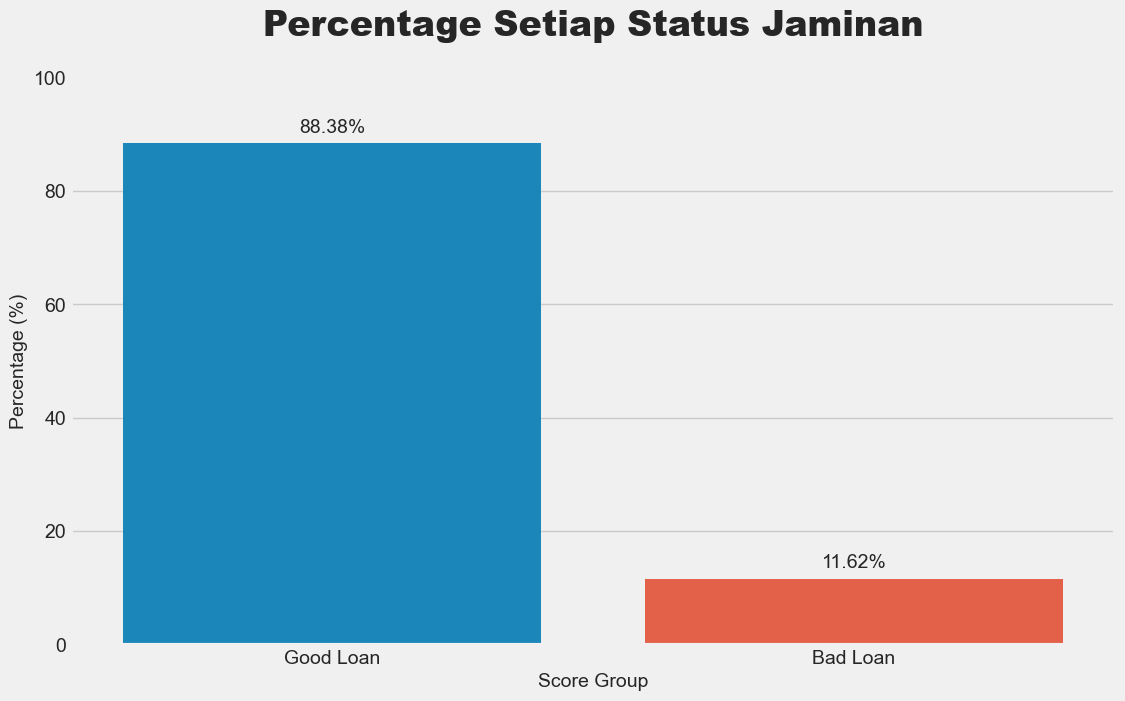

In [41]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = loan_status_groupby['loan_status'],y =loan_status_groupby['percentage'],orient='v')
plt.bar_label(ax.containers[0], padding=5,fmt='%.2f%%')
plt.title('Percentage Setiap Status Jaminan', 
          fontsize=25, weight='extra bold', pad=30)
plt.ylim(0,100)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xlabel('Score Group', fontsize=14)

#### Good loan Base on Loan Amount

In [45]:
df_vis_loan = df_vis.groupby(['score_group','loan_status','loan_amnt_fc']).agg(num_cust=('id','count')).reset_index()
total_cust_loan= df_vis_loan.groupby(['loan_amnt_fc']).agg(total_cust=('num_cust','sum')).reset_index()
df_vis_loan_group = df_vis_loan.merge(total_cust_loan,on = ['loan_amnt_fc'])
good_loan_rate = df_vis_loan_group[df_vis_loan_group['loan_status']=='Good Loan']
good_loan_rate['good_loan_rate'] = round((good_loan_rate['num_cust']/good_loan_rate['total_cust'])*100, 2)
good_loan_rate = good_loan_rate.sort_values(by='good_loan_rate', ascending=False)
good_loan_rate

C:\Users\ACER\AppData\Local\Temp\ipykernel_26336\2902224116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_loan_rate['good_loan_rate'] = round((good_loan_rate['num_cust']/good_loan_rate['total_cust'])*100, 2)


,score_group,loan_status,loan_amnt_fc,num_cust,total_cust,good_loan_rate
3,Poor (300-579),Good Loan,10850-14300,57373,64925,88.37
23,Poor (300-579),Good Loan,3950-7400,66727,75586,88.28
36,Poor (300-579),Good Loan,31550-35000,18903,21520,87.84
30,Poor (300-579),Good Loan,7400-10850,80444,91600,87.82
26,Poor (300-579),Good Loan,465-3950,24417,27835,87.72
19,Poor (300-579),Good Loan,24650-28100,23232,26562,87.46
7,Poor (300-579),Good Loan,14300-17750,53338,61015,87.42
11,Poor (300-579),Good Loan,17750-21200,50497,57857,87.28
33,Poor (300-579),Good Loan,28100-31550,11789,13583,86.79
15,Poor (300-579),Good Loan,21200-24650,22318,25802,86.50


#### Bad loan Base on Loan Amount

In [44]:
df_vis_loan = df_vis.groupby(['score_group','loan_status','loan_amnt_fc']).agg(num_cust=('id','count')).reset_index()
total_cust_loan= df_vis_loan.groupby(['loan_amnt_fc']).agg(total_cust=('num_cust','sum')).reset_index()
df_vis_loan_group = df_vis_loan.merge(total_cust_loan,on = ['loan_amnt_fc'])
bad_loan_rate = df_vis_loan_group[df_vis_loan_group['loan_status']=='Bad Loan']
bad_loan_rate['bad_loan_rate'] = round((bad_loan_rate['num_cust']/bad_loan_rate['total_cust'])*100, 2)
bad_loan_rate = bad_loan_rate.sort_values(by='bad_loan_rate', ascending=False)
bad_loan_rate

C:\Users\ACER\AppData\Local\Temp\ipykernel_26336\3728577594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_loan_rate['bad_loan_rate'] = round((bad_loan_rate['num_cust']/bad_loan_rate['total_cust'])*100, 2)


,score_group,loan_status,loan_amnt_fc,num_cust,total_cust,bad_loan_rate
32,Poor (300-579),Bad Loan,28100-31550,1770,13583,13.03
25,Poor (300-579),Bad Loan,465-3950,3416,27835,12.27
35,Poor (300-579),Bad Loan,31550-35000,2608,21520,12.12
14,Poor (300-579),Bad Loan,21200-24650,3046,25802,11.81
6,Poor (300-579),Bad Loan,14300-17750,7157,61015,11.73
18,Poor (300-579),Bad Loan,24650-28100,3109,26562,11.70
29,Poor (300-579),Bad Loan,7400-10850,10632,91600,11.61
10,Poor (300-579),Bad Loan,17750-21200,6662,57857,11.51
22,Poor (300-579),Bad Loan,3950-7400,8542,75586,11.30
2,Poor (300-579),Bad Loan,10850-14300,7160,64925,11.03


Text(0.5, 0, 'Loan Amount')

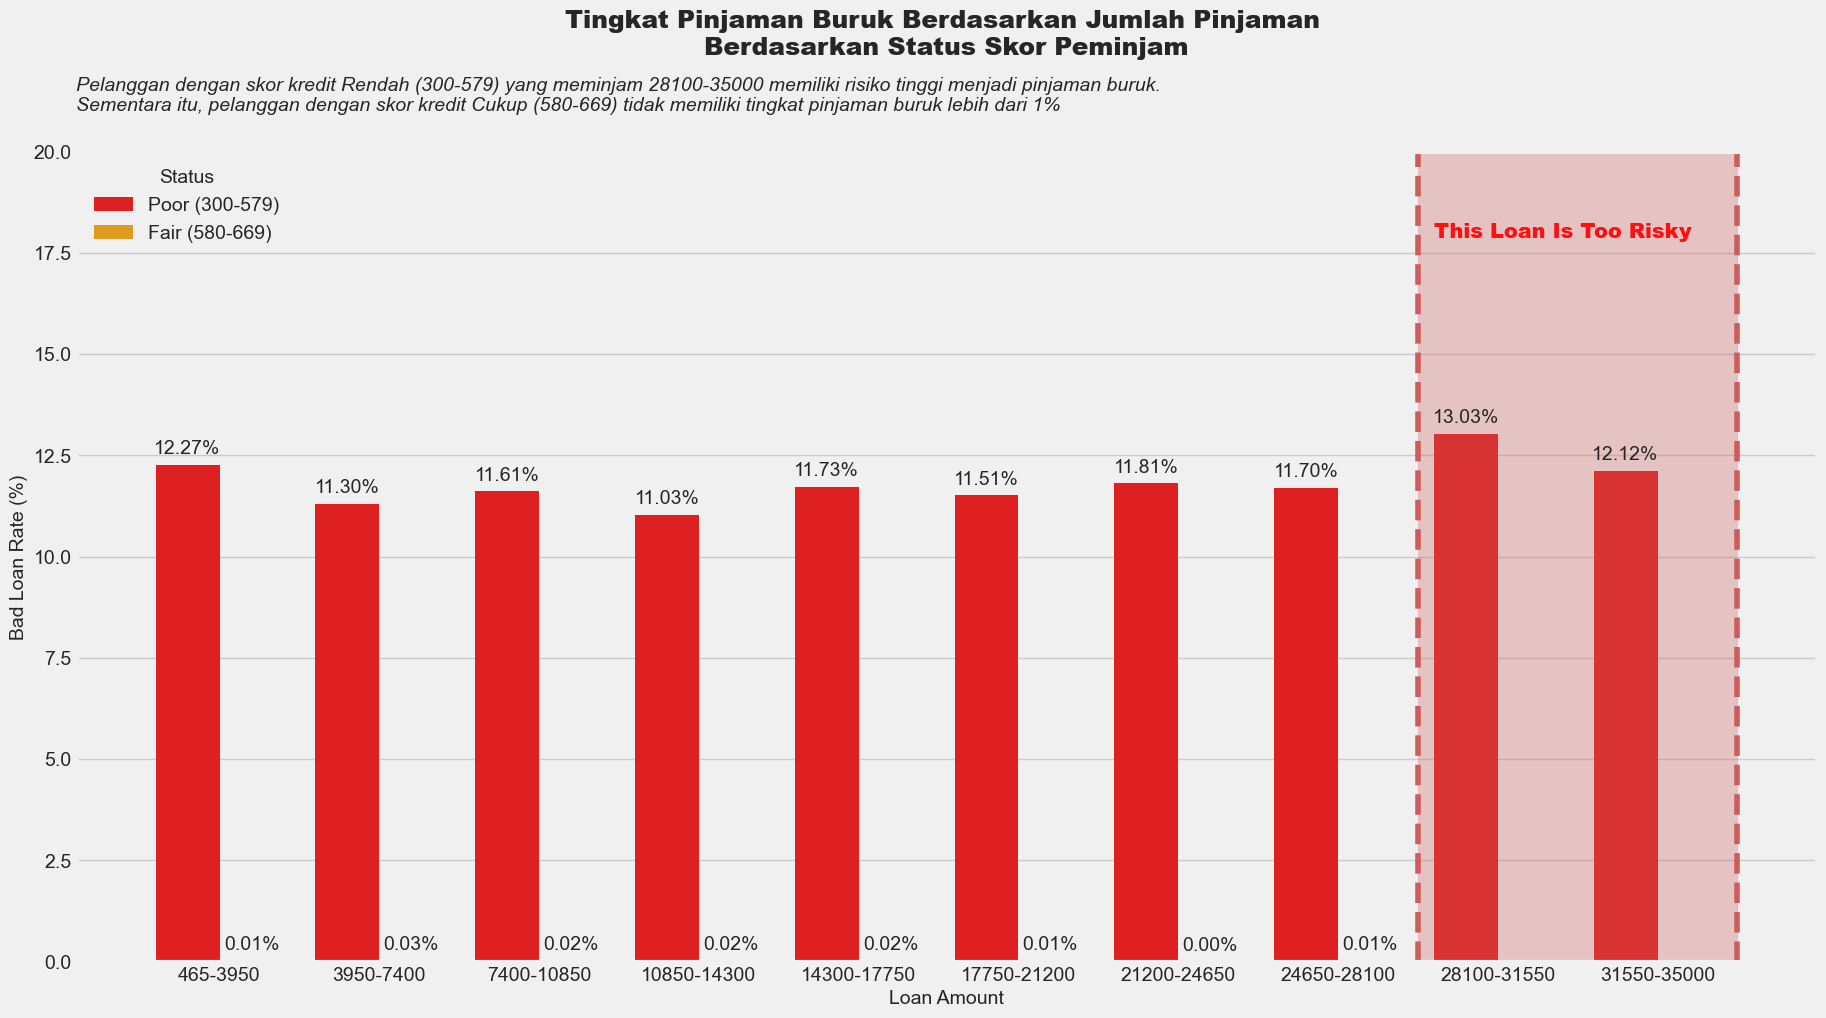

In [57]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 10))

custom_palette = {"Poor (300-579)": "red", "Fair (580-669)": "orange", "Good (670-739)": "yellow",
                  "Very Good (740-799)": "green", "Excellent (800-850)": "blue"}

sns.barplot(x='loan_amnt_fc',y='bad_loan_rate',data=bad_loan_rate,palette=custom_palette, 
              hue='score_group',ci=None, order=order_list_loan)

plt.axvline(7.5, ls='--', color='indianred')
plt.axvline(9.5, ls='--', color='indianred')
plt.stackplot(np.arange(7.5,10), [[25000]], color='indianred', alpha=0.3)
plt.text(x=7.6, y=18, s='This Loan Is Too Risky', fontsize=15, 
         color='#ff0f0f', va='center', weight='extra bold')
#plt.text(x=8, y=17, s='', fontsize=9, 
         #color='#ff0f0f', va='center', weight='extra bold')


plt.ylim(0,20)

plt.title('Tingkat Pinjaman Buruk Berdasarkan Jumlah Pinjaman \nBerdasarkan Status Skor Peminjam', 
          fontsize=18, weight='extra bold', pad=70)
plt.text(x=-0.9, y=21, s='Pelanggan dengan skor kredit Rendah (300-579) yang meminjam 28100-35000 memiliki risiko tinggi menjadi pinjaman buruk. \nSementara itu, pelanggan dengan skor kredit Cukup (580-669) tidak memiliki tingkat pinjaman buruk lebih dari 1%',
         fontstyle='italic', fontsize=14)
plt.bar_label(ax.containers[0], padding=5,fmt='%.2f%%')
plt.bar_label(ax.containers[1], padding=5,fmt='%.2f%%')

plt.legend(title='Status', loc='upper left')
plt.ylabel('Bad Loan Rate (%)', fontsize=14)
plt.xlabel('Loan Amount', fontsize=14)

#### Bad Loan Rate  Last Payment Amount

In [17]:
df_vis_payment = df_vis.groupby(['score_group','loan_status','last_pymnt_amnt_fc']).agg(num_cust=('id','count')).reset_index()
total_cust_payment= df_vis_payment.groupby(['last_pymnt_amnt_fc']).agg(total_cust=('num_cust','sum')).reset_index()
df_vis_payment_group = df_vis_payment.merge(total_cust_payment,on = ['last_pymnt_amnt_fc'])
bad_payment_rate = df_vis_payment_group[df_vis_payment_group['loan_status']=='Bad Loan']
bad_payment_rate['bad_loan_rate'] = round((bad_payment_rate['num_cust']/bad_payment_rate['total_cust'])*100, 2)
bad_payment_rate

C:\Users\ACER\AppData\Local\Temp\ipykernel_26336\112937259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_payment_rate['bad_loan_rate'] = round((bad_payment_rate['num_cust']/bad_payment_rate['total_cust'])*100, 2)


,score_group,loan_status,last_pymnt_amnt_fc,num_cust,total_cust,bad_loan_rate
0,Fair (580-669),Bad Loan,1500-3500,2,23770,0.01
2,Poor (300-579),Bad Loan,1500-3500,612,23770,2.57
4,Fair (580-669),Bad Loan,> 3500,70,112859,0.06
6,Poor (300-579),Bad Loan,> 3500,454,112859,0.40
8,Poor (300-579),Bad Loan,0-500,35560,215660,16.49
10,Poor (300-579),Bad Loan,1000-1500,1957,15162,12.91
12,Poor (300-579),Bad Loan,500-1000,15519,98834,15.70


Text(0.5, 0, 'Last Payment Amount')

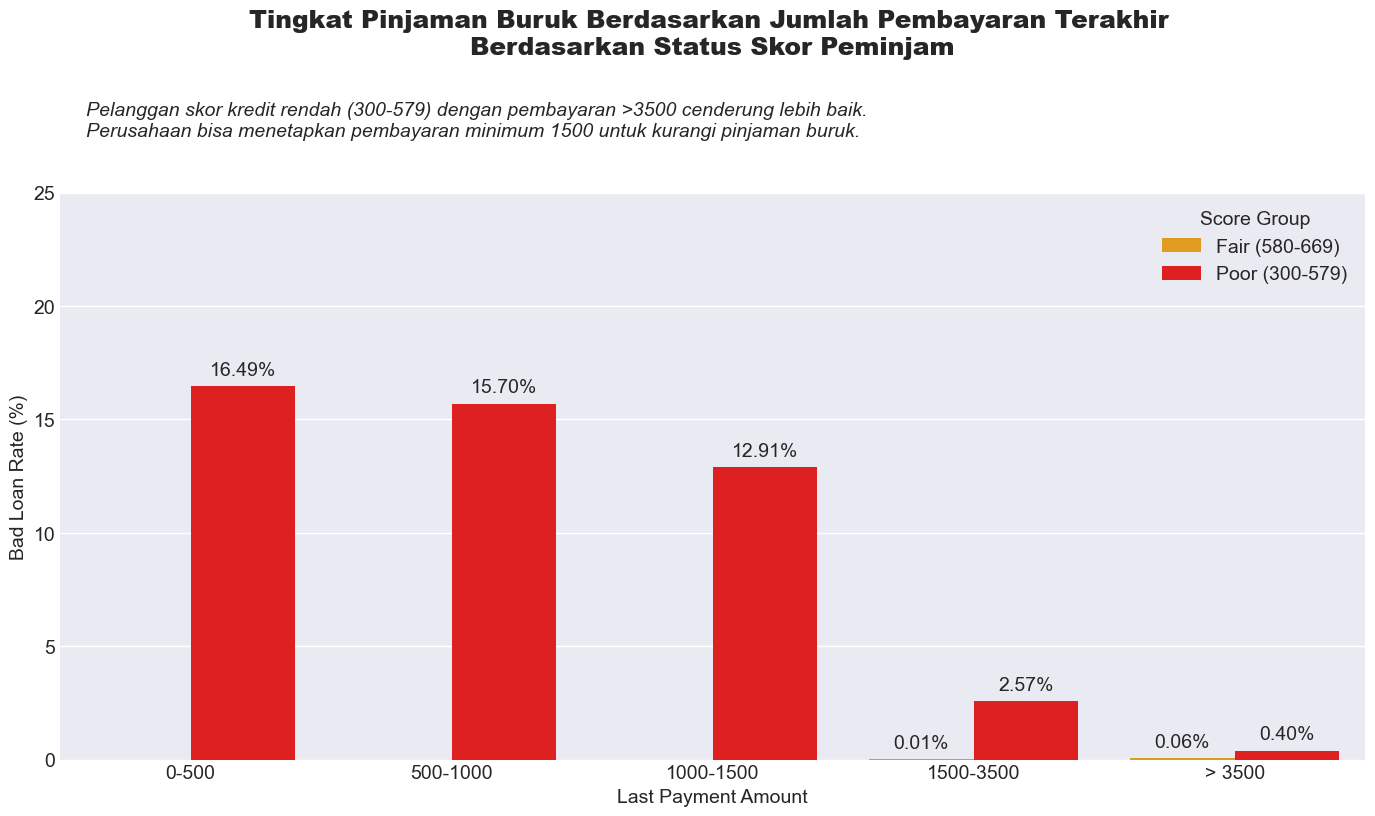

In [56]:
plt.style.use('seaborn-darkgrid')
sns.set_palette('dark')
fig, ax = plt.subplots(figsize=(15, 7))

custom_palette = {"Poor (300-579)": "red", "Fair (580-669)": "orange", "Good (670-739)": "yellow",
                  "Very Good (740-799)": "green", "Excellent (800-850)": "blue"}


sns.barplot(x='last_pymnt_amnt_fc',y='bad_loan_rate',data=bad_payment_rate,palette=custom_palette, 
              hue='score_group',ci=None, order=order_list_last_pymnt, color = 'green')

plt.bar_label(ax.containers[0], padding=5, fmt='%.2f%%')
plt.bar_label(ax.containers[1], padding=5, fmt='%.2f%%')

plt.ylim(0, 25)
plt.title('Tingkat Pinjaman Buruk Berdasarkan Jumlah Pembayaran Terakhir \nBerdasarkan Status Skor Peminjam', 
          fontsize=18, weight='extra bold', pad=100)
plt.text(x=-0.4, y=27.5, s='Pelanggan skor kredit rendah (300-579) dengan pembayaran >3500 cenderung lebih baik. \nPerusahaan bisa menetapkan pembayaran minimum 1500 untuk kurangi pinjaman buruk.',
         fontstyle='italic', fontsize=14)
plt.legend(title='Score Group', loc='upper right')
plt.ylabel('Bad Loan Rate (%)', fontsize=14)
plt.xlabel('Last Payment Amount', fontsize=14)

#### Bad Loan Rate Base on Interest Rate

In [31]:
df_vis_int = df_vis.groupby(['score_group','loan_status','int_rate_fc']).agg(num_cust=('id','count')).reset_index()
total_cust_int = df_vis_int.groupby(['int_rate_fc']).agg(total_cust=('num_cust','sum')).reset_index()
df_vis_int_group = df_vis_int.merge(total_cust_int,on = ['int_rate_fc'])
bad_int_rate = df_vis_int_group[df_vis_int_group['loan_status']=='Bad Loan']
bad_int_rate['bad_loan_rate'] = round((bad_int_rate['num_cust']/bad_int_rate['total_cust'])*100, 2)
bad_int_rate

C:\Users\ACER\AppData\Local\Temp\ipykernel_26336\288874634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_int_rate['bad_loan_rate'] = round((bad_int_rate['num_cust']/bad_int_rate['total_cust'])*100, 2)


,score_group,loan_status,int_rate_fc,num_cust,total_cust,bad_loan_rate
0,Fair (580-669),Bad Loan,11.7-13.6,25,94533,0.03
2,Poor (300-579),Bad Loan,11.7-13.6,9050,94533,9.57
4,Fair (580-669),Bad Loan,13.7-15.7,13,87615,0.01
6,Poor (300-579),Bad Loan,13.7-15.7,10897,87615,12.44
8,Fair (580-669),Bad Loan,15.8-17.8,6,60358,0.01
10,Poor (300-579),Bad Loan,15.8-17.8,9696,60358,16.06
12,Fair (580-669),Bad Loan,17.9-19.8,2,38003,0.01
14,Poor (300-579),Bad Loan,17.9-19.8,7012,38003,18.45
16,Fair (580-669),Bad Loan,19.9-21.9,1,19782,0.01
18,Poor (300-579),Bad Loan,19.9-21.9,4008,19782,20.26


Text(0.5, 0, 'Interest Rate (%)')

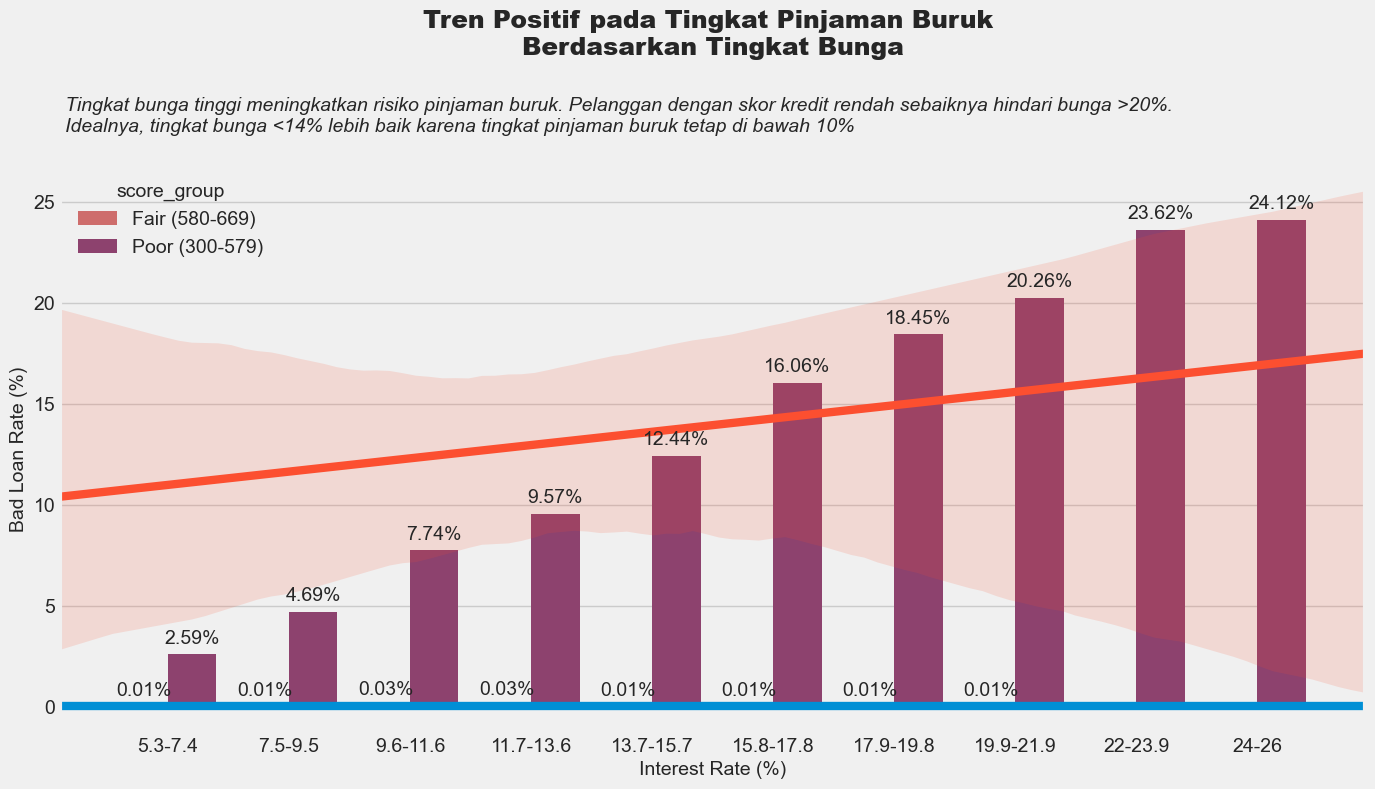

In [55]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15, 7))

sns.barplot(x='int_rate_fc',y='bad_loan_rate',data=bad_int_rate,palette='flare',  
              hue='score_group',ci=None, order=order_list_int)


sns.regplot(x=np.arange(0, len(bad_int_rate[bad_int_rate['score_group'] == 'Fair (580-669)'])), y='bad_loan_rate', 
            data=bad_int_rate[bad_int_rate['score_group'] == 'Fair (580-669)'], scatter=False, label = 'Trend Fair', truncate=False)
sns.regplot(x=np.arange(0, len(bad_int_rate[bad_int_rate['score_group'] == 'Poor (300-579)'])), y='bad_loan_rate', 
            data=bad_int_rate[bad_int_rate['score_group'] == 'Poor (300-579)'], scatter=False, label = 'Trend Poor', truncate=False)

plt.bar_label(ax.containers[0], padding=5, fmt='%.2f%%')
plt.bar_label(ax.containers[1], padding=5, fmt='%.2f%%')

#plt.ylim(0,100)
plt.title('Tren Positif pada Tingkat Pinjaman Buruk \nBerdasarkan Tingkat Bunga', 
          fontsize=18, weight='extra bold', pad=80)
plt.text(x=-0.85, y=28.5, s='Tingkat bunga tinggi meningkatkan risiko pinjaman buruk. Pelanggan dengan skor kredit rendah sebaiknya hindari bunga >20%. \nIdealnya, tingkat bunga <14% lebih baik karena tingkat pinjaman buruk tetap di bawah 10%',
         fontstyle='italic', fontsize=14)
#plt.legend(title='Status', loc='upper left')
plt.ylabel('Bad Loan Rate (%)', fontsize=14)
plt.xlabel('Interest Rate (%)', fontsize=14)

#### Good Loan Rate Based On Employment Length

In [39]:
df_vis_emp = df_vis.groupby(['emp_length','score_group','loan_status']).agg(num_cust=('id','count')).reset_index()
total_cust_emp = df_vis_emp.groupby(['emp_length']).agg(total_cust=('num_cust','sum')).reset_index()
df_vis_emp_group = df_vis_emp.merge(total_cust_emp,on = ['emp_length'])
bad_emp_rate = df_vis_emp_group[df_vis_emp_group['loan_status']=='Bad Loan']
bad_emp_rate['bad_loan_rate'] = round((bad_emp_rate['num_cust']/bad_emp_rate['total_cust'])*100, 2)

C:\Users\ACER\AppData\Local\Temp\ipykernel_26336\2320650676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_emp_rate['bad_loan_rate'] = round((bad_emp_rate['num_cust']/bad_emp_rate['total_cust'])*100, 2)


Text(0.5, 0, 'Payment Time')

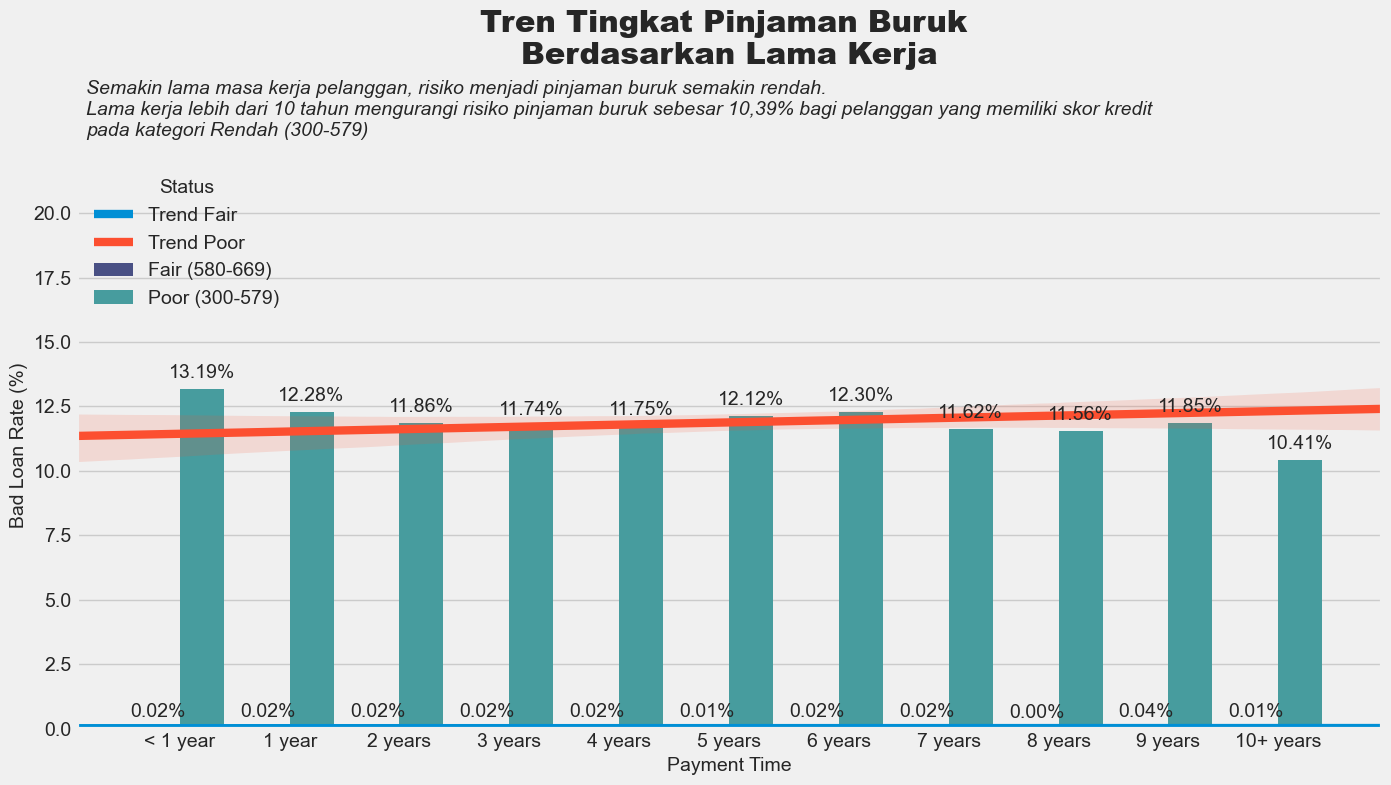

In [48]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15, 7))

sns.barplot(x='emp_length',y='bad_loan_rate',data=bad_emp_rate,palette='mako', 
              hue='score_group',ci=None, order=order_list_emp)


sns.regplot(x=np.arange(0, len(bad_emp_rate[bad_emp_rate['score_group'] == 'Fair (580-669)'])), y='bad_loan_rate', 
            data=bad_emp_rate[bad_emp_rate['score_group'] == 'Fair (580-669)'], scatter=False, label = 'Trend Fair', truncate=False)
sns.regplot(x=np.arange(0, len(bad_emp_rate[bad_emp_rate['score_group'] == 'Poor (300-579)'])), y='bad_loan_rate', 
            data=bad_emp_rate[bad_emp_rate['score_group'] == 'Poor (300-579)'], scatter=False, label = 'Trend Poor', truncate=False)

plt.bar_label(ax.containers[0], padding=5, fmt='%.2f%%')
plt.bar_label(ax.containers[1], padding=5, fmt='%.2f%%')

plt.ylim(0,22)
plt.title('Tren Tingkat Pinjaman Buruk \nBerdasarkan Lama Kerja', 
          fontsize=22, weight='extra bold', pad=70)
plt.text(x=-0.85, y=23, s='Semakin lama masa kerja pelanggan, risiko menjadi pinjaman buruk semakin rendah. \nLama kerja lebih dari 10 tahun mengurangi risiko pinjaman buruk sebesar 10,39% bagi pelanggan yang memiliki skor kredit \npada kategori Rendah (300-579)',
         fontstyle='italic', fontsize=14)
plt.legend(title='Status', loc='upper left')
plt.ylabel('Bad Loan Rate (%)', fontsize=14)
plt.xlabel('Payment Time', fontsize=14)

## Summary

Lending Companies (LC) can pay attention to customer profile that is important enough to be considered for a loan, feature like:
1. Loan Amount; The amount of the loan given is related to the interest rate that must be paid. The larger the loan amount, the higher the interest rate that must be paid. The company can recommend a loan amount that is not too risky to become a bad loan.Loan amount more than 28100 not recomend to offer for customer.
2. Last Payment Amount; More payment amount that customer take, lower the risk of the customer becoming a bad loan.Lending Companies can set limit minimum amount from 1500 for payment amount that must customer pay every due
3. Payment Time; The longer time that must be paid by the customer, the higher the risk of the customer becoming a bad loan.Limiting the payment time max 6 years can reduce the risk of bad loans
4. Interest Rate; More interest rate that customer take,increasing more bad loan rate. Ideally if lending companies want to keep bad loan low, they can offer interest rate below 14%.Lending companies mus avoid to offer loan with interest rate more than 20%.
5. Employment Length; In the visualization, it has been proven that the longer the customer's work experience, the more capable the customer is to repay the loan, thereby increasing the good loan.